# Introduction

In this first test notebook we will be using a rather old but powerfull algorithm to setup a baseline against which we can perform a comparison with SLM's and LLM's.

The K-Nearest Neighbors algorithm is called a non parametric supervised learning method. It was first developed around 1951. Even though it is old it remains a powerfull and yet very simple and very fast method compared to running inference for SLM's or LLM's on a GPU.

In [1]:
# Import Modules
import pickle
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

# Charts
import seaborn as sns
import matplotlib.pyplot as plt

# Class Labels
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']

## Load Embeddings and Labels

In [2]:
# Load
with open("./embeddings/train_embeddings.pkl", "rb") as f:
    train_embeddings = pickle.load(f)
with open("./embeddings/test_embeddings.pkl", "rb") as f:
    test_embeddings = pickle.load(f)
with open("./embeddings/train_labels.pkl", "rb") as f:
    train_labels = pickle.load(f) 
with open("./embeddings/test_labels.pkl", "rb") as f:
    test_labels = pickle.load(f)

# Summary
print(f'Train Embeddings Shape: {train_embeddings.shape}  Type: {type(train_embeddings)}')
print(f'Test Embeddings Shape: {test_embeddings.shape}  Type: {type(test_embeddings)}')
print(f'Train Labels Shape: {train_labels.shape}  Type: {type(train_labels)}')
print(f'Test Labels Shape: {test_labels.shape}  Type: {type(test_labels)}')

Train Embeddings Shape: (120000, 1024)  Type: <class 'numpy.ndarray'>
Test Embeddings Shape: (7600, 1024)  Type: <class 'numpy.ndarray'>
Train Labels Shape: (120000,)  Type: <class 'numpy.ndarray'>
Test Labels Shape: (7600,)  Type: <class 'numpy.ndarray'>


## Perform K-NearestNeighbors Sweep

In [3]:
# Placeholder
results = []

# K - Sweep
for k in tqdm(range(5, 26), desc = "K-Sweep"):
    
    # Setup and fit K-NN Classifier
    knn = KNeighborsClassifier(n_neighbors = k,
                               weights = "distance",
                               metric = "cosine",
                               algorithm = "brute")
    knn.fit(train_embeddings, train_labels)

    # Predict Test Labels
    test_pred = knn.predict(test_embeddings)

    # Accuracy
    acc = accuracy_score(test_labels, test_pred)
    print(f"===== K: {k}   Test Accuracy: {acc:.4f}")

    # Accuracy per label
    unique_labels = np.unique(test_labels)
    for lbl in unique_labels:
        label_mask = (test_labels == lbl)
        label_acc = accuracy_score(test_labels[label_mask], test_pred[label_mask])
        #print(f"   Label: {lbl}  Accuracy: {label_acc:.4f}")

        # Collect Results       
        results.append({"K": k, "Label": lbl, "Accuracy": label_acc})

# Convert to DataFrame
df_results = pd.DataFrame(results)

K-Sweep:   0%|          | 0/21 [00:00<?, ?it/s]

===== K: 5   Test Accuracy: 0.9191
===== K: 6   Test Accuracy: 0.9214
===== K: 7   Test Accuracy: 0.9229
===== K: 8   Test Accuracy: 0.9249
===== K: 9   Test Accuracy: 0.9250
===== K: 10   Test Accuracy: 0.9245
===== K: 11   Test Accuracy: 0.9238
===== K: 12   Test Accuracy: 0.9247
===== K: 13   Test Accuracy: 0.9243
===== K: 14   Test Accuracy: 0.9251
===== K: 15   Test Accuracy: 0.9239
===== K: 16   Test Accuracy: 0.9236
===== K: 17   Test Accuracy: 0.9243
===== K: 18   Test Accuracy: 0.9243
===== K: 19   Test Accuracy: 0.9239
===== K: 20   Test Accuracy: 0.9233
===== K: 21   Test Accuracy: 0.9230
===== K: 22   Test Accuracy: 0.9238
===== K: 23   Test Accuracy: 0.9245
===== K: 24   Test Accuracy: 0.9247
===== K: 25   Test Accuracy: 0.9253


## Plot average performance per Label

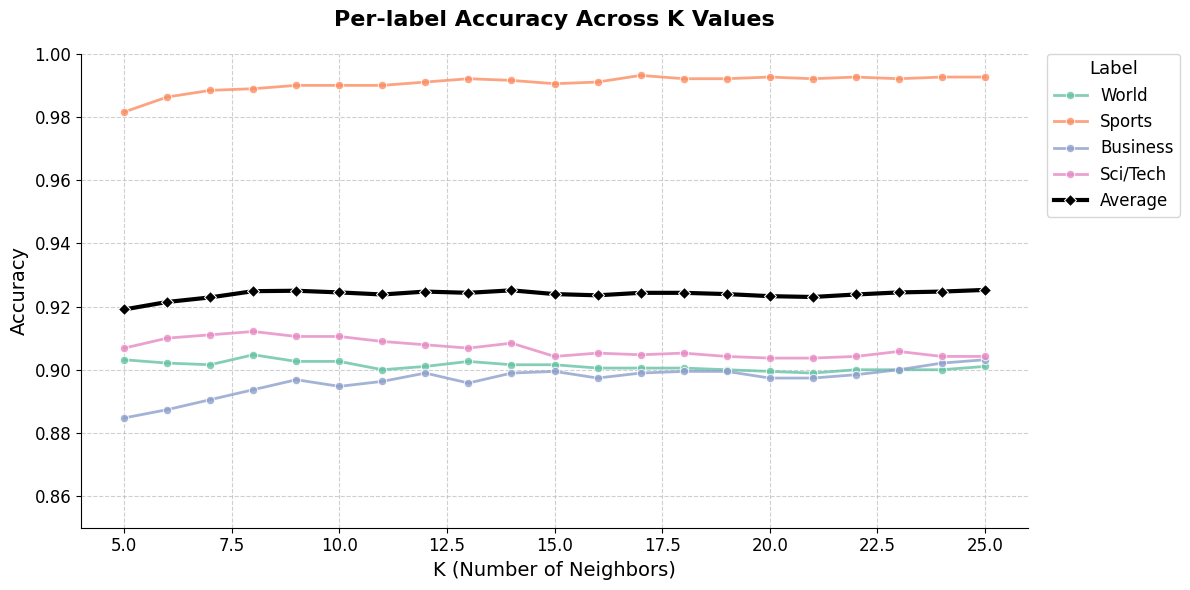

In [4]:
# Map Label Names
label_map = dict(zip(sorted(df_results["Label"].unique()), label_names))
df_results["LabelName"] = df_results["Label"].map(label_map)

# Compute average accuracy per K
df_avg = df_results.groupby("K")["Accuracy"].mean().reset_index()

# Custom Palette
palette = sns.color_palette("Set2", len(label_names))

# Set Size
plt.figure(figsize = (12, 6))

# Per-label accuracy lines
sns.lineplot(data = df_results, x = "K", y = "Accuracy", hue = "LabelName", marker = "o", palette = palette, linewidth = 2.0, alpha = 0.8)

# Average accuracy line
sns.lineplot(data = df_avg, x = "K", y = "Accuracy", color = "black", linewidth = 3, marker = "D", label = "Average")

# Styling
plt.title("Per-label Accuracy Across K Values", fontsize = 16, fontweight = "bold", pad = 20)
plt.xlabel("K (Number of Neighbors)", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0.85, 1.0)

# Legend
plt.legend(
    title="Label",
    bbox_to_anchor=(1.02, 1), loc="upper left",
    borderaxespad=0, fontsize=12, title_fontsize=13
)

# Grid and Final Layout
sns.despine()
plt.grid(True, linestyle = "--", alpha = 0.6)
plt.tight_layout()
plt.show()

## Conclusion

For the AG News subset we established a very solid baseline classifier based on K-NN with an average accuracy of 92.50%.

Let's see in the next experiments what can be achieved with a fine-tuned SLM and a basic LLM.